In [1]:
import os
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt

In [2]:
class pltData:
    def __init__(self, path):
        self.caseID = path.split('\\')[-1]
        self.pltFiles, self.eventsID = self.getPLT(path)
        self.SimulationPoints = 517 #20s de simulação representam 517 pontos no caso estudado
        

    def getPLT(self, path):
        match = re.compile('(?i).*\.plt$') #Regex p/ encontrar arquivos que terminam com '.plt' (case insensitive)
        files = [os.path.join(root,f) for root,dirs,files in os.walk(path) for f in files if match.match(str(f))]
        events = [item.upper().replace('.PLT', '').split('\\')[-1] for item in files]
        return files, events #Lista dos arquivos encontrados em path e nome dos arquivos
    
    def wrapPLT(self, plt_path):
        with open(plt_path, 'r') as file:
            lines = file.readlines()
            varNumber = int(lines[0])
            dataID = list(zip([var.split()[0] for var in lines[1:varNumber+1]], [id.split()[1] for id in lines[1:varNumber+1]]))
            assert varNumber == len(dataID), 'in wrapPLT({}): varNumber =! dataID list lenght'.format(plt_path)

            try:
                dataList = [item.replace('\n', '') for item in lines[varNumber+1:]]
                dataList = [item.split() for item in dataList]
                dataList = [float(item) for sublist in dataList for item in sublist]
            except:
                print('Could not build dataList from {}'.format(plt_path))

            dataPoints = int(len(dataList)/varNumber)

            try:
                dataArray = [dataList[var::varNumber] for var in range(0, varNumber)]
                timeSeries = dict(map(lambda i, j: (i, j), dataID, dataArray))
            except:
                print('Could not build timeSeries dictionary or dataArray from dataList of {}'.format(plt_path))
            #Retorna dados em dicionário do tipo {(variável, máquina): (data array)} e o número de pontos da simulação (517 para 20s simulados no caso estudado)
            return timeSeries, dataPoints 


In [3]:
class Event(pltData):
    def __init__(self, path):
        super().__init__(path)
    
    def newEvent(self, index, type):
        self.EventID = self.eventsID[int(index)]
        self.File = self.pltFiles[int(index)]
        self.IndexOrder = int(index)
        self.EventType = str(type)
        self.Data, self.NPoints = self.wrapPLT(self.File)
        if self.NPoints == self.SimulationPoints:
            self.Stable = 0
        else:
            self.Stable = 1

    def plotEvent(self, data, var, figsize, dpi, plot):
        X = self.Data[('Tempo', '-')]
        Y = data
        y_label = {'VOLT': 'Módulo da Tensão (V)', 'DELT': 'Fase do Ângulo do Rotor (°)', 'PGER': 'Potência Ativa (W)', 'QGER': 'Potência Reativa (W)', 'PACE': 'Potência Acelerante (W)', 'ANGL': 'Ângulo de Fase da Tensão (°)'}
        title = self.caseID+' - '+self.EventType+': '+self.EventID+' - '+str(var)
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_subplot(111)
        ax.plot(X, Y, linewidth=1)
        ax.set(title=title, ylabel=y_label[str(var[0])], xlabel='Tempo (s)')
        if plot:
            plt.show()
        else:
            return fig
    
    def plotEventSave(self, data, var, figsize, dpi):
        figure = self.plotEvent(data, var, figsize, dpi, plot=False)
        try:
            os.mkdir('figures')
        except:
            pass
        figure.savefig('figures\\'+str(self.EventType)+'_'+str(self.EventID)+'_'+str(var)+'_('+str(self.Stable)+').png')
    

In [4]:
SOURCE = 'C:\\Users\\pablo\\OneDrive - ufmt.br\\1 - Análise de Estabilidade Transitória Utilizando Aprendizagem de Máquina\\dados\\simulacoes\\dinamica\\resultados_analise_dinamica\\CASO A'
contingency = Event(SOURCE)
contingency.newEvent(12, 'CURTO CIRCUITO TRIFÁSICO')


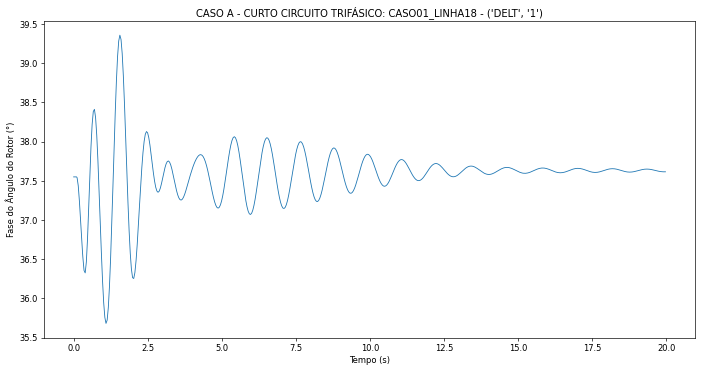

In [6]:
contingency.plotEvent(data=contingency.Data[list(contingency.Data.keys())[1]], var=list(contingency.Data.keys())[1], figsize=(14, 7), dpi=60, plot=True)

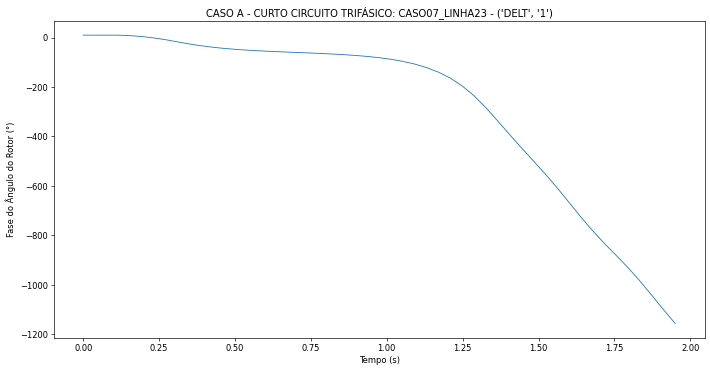

In [10]:
contingency01.plotEventSave(data=contingency01.Data[list(contingency01.Data.keys())[1]], var=list(contingency01.Data.keys())[1], figsize=(14, 7), dpi=60)